이 자료는 위키독스 딥 러닝을 이용한 자연어 처리 입문의 BiLSTM + CRF + 문자 임베딩의 튜토리얼 자료입니다.

링크 : https://wikidocs.net/147219  
링크 : https://wikidocs.net/147234  
링크 : https://wikidocs.net/147299

이 자료는 2021년 12월 27일에 마지막으로 테스트되었습니다.

In [ ]:
import tensorflow as tf
tf.__version__  ## 2024.08 JH 2.17.0

'2.17.0'

In [ ]:
######################################
tf.config.run_functions_eagerly(True)

# CRF layer 설치

In [ ]:
!pip install keras-crf==0.3.0

In [ ]:
# 모델 평가
!pip install seqeval

In [ ]:
!pip list | grep keras-crf

keras-crf                        0.3.0


# 12-05 BiLSTM을 이용한 개체명 인식(Named Entity Recognition, NER)
---

양방향 LSTM을 이용하여 개체명 인식기를 만든 후에 F1-score를 사용하여 모델을 평가합니다.

---
## 1. 개체명 인식 데이터에 대한 이해와 전처리
---

앞서 사용한 데이터와는 다른 데이터를 사용하여 개체명 인식을 수행해보겠습니다. 데이터는 아래의 링크에서 다운로드합니다.

링크 : https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

# 데이터 전처리

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import urllib.request

ner_dataset.csv를 Colab에 업로드하세요.

In [ ]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20Sequence%20Labeling/dataset/ner_dataset.csv", filename="ner_dataset.csv")
## 링크에 데이터 없음
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [ ]:
data[50:100]

,Sentence #,Word,POS,Tag
50,NaN,the,DT,O
51,NaN,Bombings,NNS,O
52,NaN,.,.,O
53,NaN,"""",``,O
54,Sentence: 3,They,PRP,O
55,NaN,marched,VBD,O
56,NaN,from,IN,O
57,NaN,the,DT,O
58,NaN,Houses,NNS,O
59,NaN,of,IN,O


데이터의 형식을 이해해봅시다. 첫번째 열 'Sentence :#'은 다음과 같은 패턴을 가지고 있습니다. Sentence: 1이 등장하고 Null 값이 이어지다가 다시 Sentence: 2가 등장하고 다시 Null 값이 이어지다가 Sentence: 3이 등장하고 다시 Null 값이 이어지다가를 반복합니다. 사실 이는 하나의 문장을 여러 행으로 나눠놓은 것입니다. 숫자값을 t라고 합시다. 첫번째 Sentence: t부터 Null 값이 나오다가 Sentence: t+1이 나오기 전까지의 모든 행은 기존에 하나의 문장이었습니다. t번째 문장을 단어 토큰화 후 각 행으로 나눠놓은 데이터이기 때문입니다. 뒤에서 Pandas의 fillna를 통해 하나로 묶는 작업을 해줍니다.

In [ ]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 1048575


현재 data의 행의 개수는 1,048,575개입니다. 하지만 뒤에서 문장 1개를 다수의 행들으로 나누어 놓은 것을 다시 1개의 행으로 병합하는 작업을 해야하기 때문에 최종 샘플의 개수는 이보다 줄어들게 됩니다. 결측값 유무를 살펴봅시다.

In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : True


Sentence #열에 Null 값들이 존재하고 있어 isnull().values.any()를 수행하였을 때 True가 나옵니다. isnull().sum()을 수행하면 각 열마다의 Null 값의 개수를 보여줍니다.

In [ ]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()

어떤 열에 Null값이 있는지 출력


,0
Sentence #,1000616
Word,10
POS,0
Tag,0


다른 열은 0개인데 오직 Sentences #열에서만 1,000,616개가 나온 것을 볼 수 있습니다. 전체 데이터에서 중복을 허용하지 않고 유일한 값의 개수를 셀 수 있게 해주는 nunique()를 사용해봅시다.

In [ ]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35177
Tag 열의 중복을 제거한 값의 개수 : 17


이 데이터에는 47,959개의 문장이 있으며 문장들은 35,178개의 단어를 가지고 17개 종류의 개체명 태깅을 가집니다. 17개의 개체명 태깅이 전체 데이터에서 몇 개가 있는지, 개체명 태깅 개수의 분포를 확인해보도록 하겠습니다.

In [ ]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


BIO 표현 방법에서 아무런 태깅도 의미하지 않는 O가 가장 887,908개로 가장 많은 개수를 차지함을 볼 수 있습니다. 데이터를 원하는 형태로 가공해보겠습니다. 우선 Null 값을 제거합니다. Pandas의 fillna(method='ffill')는 Null 값을 가진 행의 바로 앞의 행의 값으로 Null 값을 채우는 작업을 수행합니다. t번째 문장에 속하면서 Null 값을 가진 샘플들은 전부 첫번째 열에 Sentence: t의 값이 들어갑니다. 이번에는 뒤의 5개의 샘플을 출력해서 정상적으로 수행되었는지 확인해봅시다.

In [ ]:
data = data.fillna(method="ffill")

<ipython-input-120-c269da69c753>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


In [ ]:
data[:30]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


뒤의 5개 샘플의 첫번째 열이 Sentence: 47959로 채워졌습니다. 이는 47,959번째 문장임을 의미하며, Null 값을 가진 행들의 바로 앞 행의 Sentence # 열의 값이 Sentence: 47959이었음을 의미합니다. 전체 데이터에 Null 값이 존재하는지 확인해봅시다.

In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


없는 것으로 나옵니다. 모든 단어를 소문자화하여 단어의 개수를 줄여보겠습니다.

In [ ]:
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 31817


In [ ]:
data.Word.shape

(1048575,)

정상적으로 소문자화가 되었는지 앞의 샘플 5개만 출력해보겠습니다.

In [ ]:
print(data[:5])

    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


하나의 문장에 등장한 단어와 개체명 태깅 정보끼리 쌍(pair)으로 묶는 작업을 수행합니다.

In [ ]:
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 47959


1,000,616개의 행의 개수가 각 문장당 하나의 샘플로 묶이면서 47,959개의 샘플이 되었습니다. 정상적으로 수행되었는지 첫번째 샘플을 출력해봅시다.

In [ ]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


전처리가 수행된 첫번째 샘플이 출력됩니다. 이러한 샘플이 총 47,959개가 있습니다. 그런데 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 개체명 태깅 정보에 해당되는 부분을 분리시켜야 합니다. 즉, [('thousands', 'O'), ('of', 'O')]와 같은 문장 샘플이 있다면 thousands와 of는 같이 저장하고, O와 O를 같이 저장할 필요가 있습니다. 동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소들끼리 묶어주는 역할을 하는 zip()을 사용하여 단어와 개체명 태깅 정보를 분리해봅시다.

In [ ]:
tagged_sentences[:2]

[[('thousands', 'O'),
  ('of', 'O'),
  ('demonstrators', 'O'),
  ('have', 'O'),
  ('marched', 'O'),
  ('through', 'O'),
  ('london', 'B-geo'),
  ('to', 'O'),
  ('protest', 'O'),
  ('the', 'O'),
  ('war', 'O'),
  ('in', 'O'),
  ('iraq', 'B-geo'),
  ('and', 'O'),
  ('demand', 'O'),
  ('the', 'O'),
  ('withdrawal', 'O'),
  ('of', 'O'),
  ('british', 'B-gpe'),
  ('troops', 'O'),
  ('from', 'O'),
  ('that', 'O'),
  ('country', 'O'),
  ('.', 'O')],
 [('iranian', 'B-gpe'),
  ('officials', 'O'),
  ('say', 'O'),
  ('they', 'O'),
  ('expect', 'O'),
  ('to', 'O'),
  ('get', 'O'),
  ('access', 'O'),
  ('to', 'O'),
  ('sealed', 'O'),
  ('sensitive', 'O'),
  ('parts', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('plant', 'O'),
  ('wednesday', 'B-tim'),
  (',', 'O'),
  ('after', 'O'),
  ('an', 'O'),
  ('iaea', 'B-org'),
  ('surveillance', 'O'),
  ('system', 'O'),
  ('begins', 'O'),
  ('functioning', 'O'),
  ('.', 'O')]]

In [ ]:
list(zip(*tagged_sentences[0]))

[('thousands',
  'of',
  'demonstrators',
  'have',
  'marched',
  'through',
  'london',
  'to',
  'protest',
  'the',
  'war',
  'in',
  'iraq',
  'and',
  'demand',
  'the',
  'withdrawal',
  'of',
  'british',
  'troops',
  'from',
  'that',
  'country',
  '.'),
 ('O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-gpe',
  'O',
  'O',
  'O',
  'O',
  'O')]

In [ ]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

각 문장 샘플에서 단어는 sentences에 태깅 정보는 ner_tags에 저장하였습니다. 임의로 첫번째 문장 샘플을 출력해보겠습니다.

In [ ]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


첫번째 샘플에 대해서 단어에 대해서만 sentences[0]에, 또한 개체명에 대해서만 ner_tags[0]에 저장된 것을 볼 수 있습니다. 뒤에서 보겠지만, sentences는 예측을 위한 X에 해당되며 ner_tags는 예측 대상인 y에 해당됩니다. 다른 샘플들에 대해서도 처리가 되었는지 확인하기 위해 임의로 98번 인덱스의 샘플에 대해서도 확인해보겠습니다.

In [ ]:
print(sentences[98])
print(ner_tags[98])

['she', 'had', 'once', 'received', 'a', 'kidney', 'transplant', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


단어에 대해서만 sentences[98]에, 또한 개체명에 대해서만 ner_tags[98]에 저장된 것을 확인할 수 있습니다. 또한 첫번째 샘플과 길이가 다릅니다. 47,959개의 문장 샘플의 길이는 서로 다를 수 있습니다. 전체 데이터의 길이 분포를 확인해봅시다.

샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


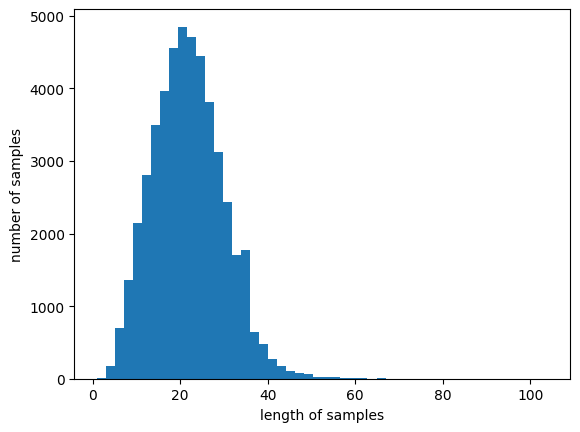

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프는 샘플들의 길이가 대체적으로 0~40의 길이를 가지는 것을 보여줍니다. 길이가 가장 긴 샘플의 길이는 104입니다. 케라스 토크나이저를 통해서 정수 인코딩을 진행합니다. 이번에는 문장 데이터에 있는 모든 단어를 사용하겠습니다.

In [ ]:
# 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer = Tokenizer(oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)
# 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer = Tokenizer(lower=False)
tar_tokenizer.fit_on_texts(ner_tags)

문장 데이터에 대해서는 src_tokenizer를, 레이블에 해당되는 개체명 태깅 정보에 대해서는 tar_tokenizer를 사용합니다.

In [ ]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [ ]:
tar_tokenizer.word_index

{'O': 1,
 'B-geo': 2,
 'B-tim': 3,
 'B-org': 4,
 'I-per': 5,
 'B-per': 6,
 'I-org': 7,
 'B-gpe': 8,
 'I-geo': 9,
 'I-tim': 10,
 'B-art': 11,
 'B-eve': 12,
 'I-art': 13,
 'I-eve': 14,
 'B-nat': 15,
 'I-gpe': 16,
 'I-nat': 17}

앞서 src_tokenizer를 만들때 Tokenizer의 인자로 oov_token='OOV'를 선택했습니다. 인덱스1에 단어 'OOV'가 할당됩니다.

In [ ]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


정수 인코딩을 수행합니다.

In [ ]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

문장 데이터에 대해서 정수 인코딩이 수행된 결과는 X_data, 개체명 태깅 데이터에 대해서 정수 인코딩이 수행된 결과는 y_data에 저장되었습니다. 정수 인코딩이 되었는지 확인을 위해 임의로 첫번째 샘플을 출력해보겠습니다.

In [ ]:
print(X_data[0])
print(y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


모델 훈련 후 결과 확인을 위해 인덱스로부터 단어를 리턴하는 index_to_word와 인덱스로부터 개체명 태깅 정보를 리턴하는 index_to_ner를 만듭니다. 인덱스 0은 'PAD'란 단어를 할당해둡니다. index_to_ner은 개수가 적으니 출력해봅시다.

In [ ]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [ ]:
print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


index_to_word를 통해 첫번째 샘플의 정수 시퀀스를 텍스트 시퀀스로 변환하는 디코딩 작업을 해보겠습니다.

In [ ]:
decoded = []
for index in X_data[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


X 데이터와 y 데이터가 구성되었습니다. 패딩 작업을 진행해봅시다. 앞서 확인하였듯이 대부분의 데이터의 길이는 40~60에 분포되어져 있습니다. 그러므로 가장 긴 샘플의 길이인 104가 아니라 70정도로 max_len을 정해보겠습니다.

In [ ]:
max_len = 70
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [ ]:
print(X_data.shape)
print(y_data.shape)

(47959, 70)
(47959, 70)


모든 샘플의 길이가 70이 되었습니다. 훈련 데이터와 테스트 데이터를 8:2의 비율로 분리합니다.

In [ ]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=.2, random_state=777)

레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩을 수행합니다.

In [ ]:
y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

각 데이터 크기를 확인해보겠습니다.

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블(정수 인코딩)의 크기 : (38367, 70)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블(정수 인코딩)의 크기 : (9592, 70)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (9592, 70, 18)


---
## 2. 양방향 LSTM을 이용한 개체명 인식
---

하이퍼파라미터인 임베딩 벡터의 차원은 128, 은닉 상태의 크기는 256입니다. 모델은 다 대 다 구조의 양방향 LSTM을 사용합니다. 이 경우 LSTM의 return_sequences의 인자값은 True로 주어야만 합니다. 이번 실습과 같이 각 데이터의 길이가 달라서 패딩을 하느라 숫자 0이 많아질 경우에는 Embedding()에 mask_zero=True를 설정하여 숫자 0은 연산에서 제외시킨다는 옵션을 줄 수 있습니다. 출력층에 TimeDistributed()를 사용했는데, TimeDistributed()는 LSTM을 다 대 다 구조로 사용하여 LSTM의 모든 시점에 대해서 출력층을 사용할 필요가 있을 때 사용합니다.

해당 모델은 모든 시점에 대해서 개체명 레이블 개수만큼의 선택지 중 하나를 예측하는 다중 클래스 분류 문제를 수행하는 모델입니다. 다중 클래스 분류 문제의 경우, 출력층에 소프트맥스 회귀를 사용해야 하므로 활성화 함수로는 소프트맥스 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용합니다. 하이퍼파라미터인 배치 크기는 128이며, 6 에포크를 수행합니다. validation_split=0.1을 사용하여 훈련 데이터의 10%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인합니다. 검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용됩니다.

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((38367, 70), (38367, 70, 18), (9592, 70), (9592, 70, 18))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
%%time
# 2024.08 Colab GPU : Accuracy가 0.3 수준???
# Epoch 6/6
# 270/270 ━━━━━━━━━━━━━━━━━━━━ 83s 309ms/step - accuracy: 0.3046 - loss: 0.0686 - val_accuracy: 0.2995 - val_loss: 0.1407
# CPU times: user 7min 36s, sys: 5.25 s, total: 7min 41s
# Wall time: 8min 9s
# history = model.fit(X_train, y_train, batch_size=512, epochs=10, validation_split=0.1)
history = model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.1)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/6
270/270 ━━━━━━━━━━━━━━━━━━━━ 90s 303ms/step - accuracy: 0.2793 - loss: 0.8618 - val_accuracy: 0.2931 - val_loss: 0.2181
Epoch 2/6
270/270 ━━━━━━━━━━━━━━━━━━━━ 81s 299ms/step - accuracy: 0.2960 - loss: 0.1785 - val_accuracy: 0.2985 - val_loss: 0.1481
Epoch 3/6
270/270 ━━━━━━━━━━━━━━━━━━━━ 79s 290ms/step - accuracy: 0.3014 - loss: 0.1165 - val_accuracy: 0.2996 - val_loss: 0.1351
Epoch 4/6
270/270 ━━━━━━━━━━━━━━━━━━━━ 79s 291ms/step - accuracy: 0.3033 - loss: 0.0940 - val_accuracy: 0.2997 - val_loss: 0.1342
Epoch 5/6
270/270 ━━━━━━━━━━━━━━━━━━━━ 78s 288ms/step - accuracy: 0.3042 - loss: 0.0780 - val_accuracy: 0.2993 - val_loss: 0.1359
Epoch 6/6
270/270 ━━━━━━━━━━━━━━━━━━━━ 83s 309ms/step - accuracy: 0.3046 - loss: 0.0686 - val_accuracy: 0.2995 - val_loss: 0.1407
CPU times: user 7min 36s, sys: 5.25 s, total: 7min 41s
Wall time: 8min 9s


검증 데이터에 대해서 약 95%의 정확도를 얻습니다. 테스트 데이터의 임의의 인덱스 13번 샘플에 대해서 실제값과 예측값을 비교해봅시다.

In [ ]:
i = 15 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경함.
labels = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
단어             |실제값  |예측값
-----------------------------------
mexican          : B-gpe   B-gpe
president        : B-per   B-per
felipe           : I-per   I-per
calderon         : I-per   I-per
has              : O       O
condemned        : O       O
an               : O       O
attack           : O       O
on               : O       O
a                : O       O
chihuahua        : B-org   B-geo
drug             : O       O
rehabilitation   : O       O
facility         : O       O
that             : O       O
left             : O       O
19               : O       O
people           : O       O
dead             : O       O
.                : O       O


정확하게 예측했습니다. F1-score라는 성능 평가 방법에 대해서 이해하고, 테스트 데이터에 대해서 성능을 측정해봅시다.

---
## 3. F1-score
---

개체명 인식에서는 그 어떤 개체도 아니라는 의미의 'O'라는 태깅이 존재합니다. 그런데 이런 정보는 보통 대다수의 레이블을 차지하기 때문에 기존에 사용했던 정확도(accuracy)를 평가 방법으로 사용하는 것이 적절하지 않을 수 있습니다.

예를 들어 모델이 단 1개의 개체도 맞추지 못하고 전부 'O'로 예상했을 경우를 봅시다. 실제값은 위에서 출력했던 값을 실제값으로 재사용하겠습니다. 아래 코드에서는 labels라는 변수에 저장하였습니다. 그리고 개체를 하나도 맞추지 못했다는 가정하에 전부 'O'로만 채워진 예측값 predicted를 생성합니다.

In [ ]:
labels = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted = ['O'] * len(labels)
print('예측값 :',predicted)

예측값 : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


실제로는 PER, MISC, PER, MISC, PER이라는 총 5개의 개체가 존재함에도 불구하고 예측값인 predicted는 단 1개의 개체도 맞추지 못한 상황을 시뮬레이션하는 것입니다. 이에 대한 정확도를 계산해봅시다.

In [ ]:
hit = 0 # 정답 개수
for tag, pred in zip(labels, predicted):
    if tag == pred:
        hit +=1 # 정답인 경우에만 +1
accuracy = hit/len(labels) # 정답 개수를 총 개수로 나눈다.
print("정확도: {:.1%}".format(accuracy))

정확도: 74.4%


실제값에서도 대부분의 값이 'O'이기 때문에 그 어떤 개체도 찾지 못하였음에도 74%의 정확도를 얻습니다. 이는 정확도가 뻥튀기되어 모델의 성능을 오해할 수 있다는 문제가 있습니다. 그래서 여기서는 위와 같은 상황에서 더 적절한 평가 방법을 도입하고자 합니다. 파이썬 패키지 seqeval를 설치합니다.

In [ ]:
pip install seqeval

앞서 머신 러닝 훑어보기 챕터에서 정밀도(precision)과 재현률(recall)을 언급한 바 있습니다. 개체명 인식 모델의 성능 측정을 위해 정밀도와 재현률 개념을 사용해보겠습니다. 이를 개체명 인식 문제에 맞도록 해석해보면 다음과 같습니다.

재현률

$$\text{정밀도} = \frac{TP}{TP + FP} = \text{특정 개체라고 예측한 경우 중에서 실제 특정 개체로 판명되어 예측이 일치한 비율}$$
    
$$\text{재현률} = \frac{TP}{TP + FN} = \text{전체 특정 개체 중에서 실제 특정 개체라고 정답을 맞춘 비율}$$

정밀도와 재현률로부터 조화 평균(harmonic mean)을 구한 것을 f1-score라고 합니다.
$$f1\ score = 2 × \frac{\text{정밀도 × 재현률}}{\text{정밀도 + 재현률}}$$

predicted의 성능을 평가하기 위해서 정밀도, 재현률, f1-score를 계산해보도록 하겠습니다.

In [ ]:
from seqeval.metrics import classification_report
print(classification_report([labels], [predicted]))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         2
         PER       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00         5
   macro avg       0.00      0.00      0.00         5
weighted avg       0.00      0.00      0.00         5



/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


이러한 측정 방법을 사용하면 PER과 MISC 두 특정 개체 중에서 실제 predicted가 맞춘 것은 단 1개도 없는 것을 확인할 수 있습니다. 이번에는 어느 정도는 정답을 맞추었다고 가정하고 예측값인 predicted를 수정하여 정밀도, 재현률, f1-score를 확인해봅시다.

In [ ]:
labels = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O']

print(classification_report([labels], [predicted]))

              precision    recall  f1-score   support

        MISC       1.00      0.50      0.67         2
         PER       1.00      0.67      0.80         3

   micro avg       1.00      0.60      0.75         5
   macro avg       1.00      0.58      0.73         5
weighted avg       1.00      0.60      0.75         5



특정 개체로 예측한 경우에 대해서는 모두 제대로 예측을 하였으므로 정밀도는 1이 나옵니다. 하지만 재현률에서는 MISC는 실제로는 4개임에도 2개만을 맞추었으므로 0.5, PER은 실제로는 3개임에도 2개만을 맞추었으므로 0.67이 나온 것을 볼 수 있습니다.

---
## 4. F1-score로 성능 측정하기
---
F1-score를 계산하기 위해서 개체명 태깅의 확률 벡터 또는 원-핫 벡터로부터 태깅 정보 시퀀스로 변환하는 함수인 sequences_to_tag를 만듭니다. 해당 함수를 통해 모델의 예측값인 y_predicted와 실제값에 해당하는 y_test를 태깅 정보 시퀀스로 변환합니다. 그리고 두 개를 비교하여 f1-score를 계산합니다.

In [ ]:
from seqeval.metrics import f1_score, classification_report

def sequences_to_tag(sequences):
    result = []
    # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
    for sequence in sequences:
        word_sequence = []
        # 시퀀스로부터 확률 벡터 또는 원-핫 벡터를 하나씩 꺼낸다.
        for pred in sequence:
            # 정수로 변환. 예를 들어 pred가 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            pred_index = np.argmax(pred)
            # index_to_ner을 사용하여 정수를 태깅 정보로 변환. 'PAD'는 'O'로 변경.
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)
    return result

y_predicted = model.predict([X_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

300/300 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step
F1-score: 78.8%
              precision    recall  f1-score   support

         art       0.33      0.06      0.11        63
         eve       0.50      0.27      0.35        52
         geo       0.82      0.86      0.84      7620
         gpe       0.96      0.94      0.95      3145
         nat       0.50      0.22      0.30        37
         org       0.63      0.53      0.58      4033
         per       0.71      0.71      0.71      3545
         tim       0.86      0.83      0.84      4067

   micro avg       0.80      0.78      0.79     22562
   macro avg       0.66      0.55      0.58     22562
weighted avg       0.79      0.78      0.78     22562



이어서 CRF 층을 추가하여 성능을 높여봅시다.

마지막 편집일시 : 2022년 11월 14일 4:25 오후

---
---

# 12-06 BiLSTM-CRF를 이용한 개체명 인식
---

이번 실습은 아래의 실습은 이미 실행한 상태라고 가정합니다.

이전 실습 링크 : https://wikidocs.net/147219

이번에는 기존의 양방향 LSTM 모델에 CRF(Conditional Random Field)라는 새로운 층을 추가하여 보다 모델을 개선시킨 양방향 LSTM + CRF 모델을 사용하여 개체명 인식(Named Entity Recognition)을 수행합니다.

논문 링크 : https://arxiv.org/pdf/1508.01991v1.pdf
논문 링크 : https://arxiv.org/pdf/1603.01360.pdf

---
##1. CRF(Conditional Random Field)
---
CRF는 Conditional Random Field의 약자로 양방향 LSTM을 위해 탄생한 모델이 아니라 이전에 독자적으로 존재해왔던 모델입니다. 이를 양방향 LSTM 모델 위에 하나의 층으로 추가하여, 양방향 LSTM + CRF 모델이 탄생하였습니다. 여기서는 CRF의 수식적 이해가 아니라 양방향 LSTM + CRF 모델의 직관에 대해서 이해합니다.

CRF 층의 역할을 이해하기 위해서 간단한 개체명 인식 작업의 예를 들어보겠습니다. 사람(Person), 조직(Organization) 두 가지만을 태깅하는 간단한 태깅 작업에 BIO 표현을 사용한다면 여기서 사용하는 태깅의 종류는 아래의 5가지입니다.

```
B-Per, I-Per, B-Org, I-Org, O
```
  
아래의 그림은 위의 태깅을 수행하는 기존의 양방향 LSTM 개체명 인식 모델의 예를 보여줍니다.

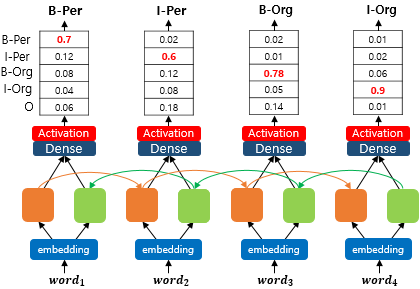

위 모델은 각 단어를 벡터로 입력받고, 모델의 출력층에서 활성화 함수를 통해 개체명을 예측합니다. 사실 입력 단어들과 실제 개체명이 무엇인지 모르는 상황이므로 이 모델이 정확하게 개체명을 예측했는지는 위 그림만으로는 알 수 없습니다. 또 다른 예를 보겠습니다.  
  
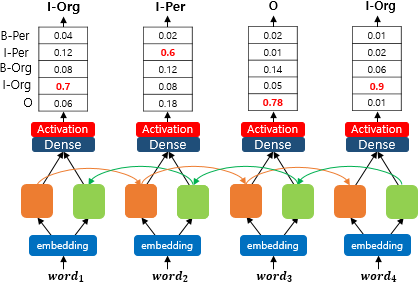  

위 모델은 명확히 틀린 예측을 포함하고 있습니다. 입력 단어들과 실제값의 여부와 상관없이 이 사실을 알 수 있습니다. BIO 표현에 따르면 우선, 첫번째 단어의 레이블에서 I가 등장할 수 없습니다. 또한 I-Per은 반드시 B-Per 뒤에서만 등장할 수 있습니다. 뿐만 아니라, I-Org도 마찬가지로 B-Org 뒤에서만 등장할 수 있는데 위 모델은 이런 BIO 표현 방법의 제약사항들을 모두 위반하고 있습니다.

여기서 양방향 LSTM 위에 CRF 층을 추가하여 얻을 수 있는 이점을 언급하겠습니다. CRF 층을 추가하면 모델은 예측 개체명, 다시 말해 레이블 사이의 의존성을 고려할 수 있습니다. 아래의 그림은 양방향 LSTM + CRF 모델을 보여줍니다.  
  
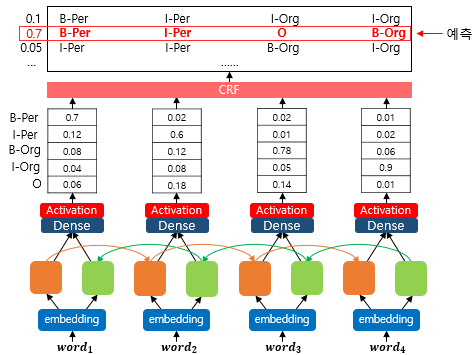

앞서봤듯이, 기존에 CRF 층이 존재하지 않았던 양방향 LSTM 모델은 활성화 함수를 지난 시점에서 개체명을 결정했지만, CRF 층을 추가한 모델에서는 활성화 함수의 결과들이 CRF 층의 입력으로 전달됩니다. 예를 들어 $word_{1}$에 대한 양방향 LSTM 셀과 활성화 함수를 지난 출력값 [0.7, 0.12, 0.08, 0.04, 0.06]은 CRF 층의 입력이 됩니다. 마찬가지로 모든 단어에 대한 활성화 함수를 지난 출력값은 CRF 층의 입력이 되고, CRF 층은 레이블 시퀀스에 대해서 가장 높은 점수를 가지는 시퀀스를 예측합니다.

이러한 구조에서 CRF 층은 점차적으로 훈련 데이터로부터 아래와 같은 제약사항 등을 학습하게 됩니다.  
  
1. 문장의 첫번째 단어에서는 I가 나오지 않습니다.
2. O-I 패턴은 나오지 않습니다.
3. B-I-I 패턴에서 개체명은 일관성을 유지합니다. 예를 들어 B-Per 다음에 I-Org는 나오지 않습니다.  
  
요약하면 양방향 LSTM은 입력 단어에 대한 양방향 문맥을 반영하며, CRF는 출력 레이블에 대한 양방향 문맥을 반영합니다.

---
## 2. CRF 층 설치하기
---
CRF 층을 손쉽게 사용하기 위한 keras-crf를 설치합니다.

In [ ]:
pip install keras-crf

깃허브 링크 : https://github.com/luozhouyang/keras-crf

---
## 3. BiLSTM-CRF를 이용한 개체명 인식
---
이전과 동일한 데이터에 대해서 모델을 학습해봅시다. 마지막 층에 CRF 층을 추가하기 위하여 함수형 API를 사용합니다. 하이퍼파라미터인 임베딩 벡터의 차원은 128, 은닉 상태의 크기는 64입니다. 모델은 다 대 다 구조의 양방향 LSTM을 사용합니다. 이 경우 LSTM의 return_sequences의 인자값은 True로 주어야만 합니다. 출력층에 TimeDistributed()를 사용했는데, TimeDistributed()는 LSTM을 다 대 다 구조로 사용하여 LSTM의 모든 시점에 대해서 출력층을 사용할 필요가 있을 때 사용합니다.

해당 모델은 모든 시점에 대해서 개체명 레이블 개수만큼의 선택지 중 하나를 예측하는 다중 클래스 분류 문제를 수행하는 모델입니다. 여기서는 최종 출력층이 CRF 층으로 CRF 층에 분류해야 하는 선택지 개수를 의미하는 tag_size를 전달해줍니다.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras_crf import CRFModel   # tensorflow 2.17과 호환 안됨 (Dependancy 문제)
from seqeval.metrics import f1_score, classification_report

embedding_dim = 128
hidden_units = 64
dropout_ratio = 0.3

sequence_input = Input(shape=(max_len,),dtype=tf.int32, name='sequence_input')

model_embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len)(sequence_input)

model_bilstm = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(model_embedding)

model_dropout = TimeDistributed(Dropout(dropout_ratio))(model_bilstm)

model_dense = TimeDistributed(Dense(tag_size, activation='relu'))(model_dropout)

base = Model(inputs=sequence_input, outputs=model_dense)
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


NameError: name 'CRFModel' is not defined

In [ ]:
model.summary()

Model: "crf_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_input (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 70, 128)      4072832     ['sequence_input[0][0]']         
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 70, 128)     98816       ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 70, 128)     0           ['bidirectional_1[0][0]']

하이퍼파라미터인 배치 크기는 128이며, 15 에포크를 수행합니다. validation_split=0.1을 사용하여 훈련 데이터의 10%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인합니다. 검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용됩니다. 조기 종료를 사용하기 위해서 콜백을 정의합니다. keras-crf가 원-핫 인코딩 된 레이블은 지원하지 않으므로 y_train이 아니라 y_train_int를 사용함을 주의합니다.

In [ ]:
%%time
# 270/270 [==============================] - 29s 108ms/step - decode_sequence_accuracy: 0.9913 - loss: 1.2541 - val_decode_sequence_accuracy: 0.9854 - val_loss: 3.4207
# Epoch 9: early stopping
# CPU times: user 9min 51s, sys: 1min 30s, total: 11min 21s
# Wall time: 4min 37s
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit(X_train, y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9236 - loss: 26.0134
Epoch 1: val_decode_sequence_accuracy improved from -inf to 0.95916, saving model to bilstm_crf/cp.ckpt
270/270 [==============================] - 37s 118ms/step - decode_sequence_accuracy: 0.9236 - loss: 25.9491 - val_decode_sequence_accuracy: 0.9592 - val_loss: 9.5887
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9704 - loss: 6.7198
Epoch 2: val_decode_sequence_accuracy improved from 0.95916 to 0.98001, saving model to bilstm_crf/cp.ckpt
270/270 [==============================] - 31s 114ms/step - decode_sequence_accuracy: 0.9704 - loss: 6.7134 - val_decode_sequence_accuracy: 0.9800 - val_loss: 4.7821
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9827 - loss: 3.5354
Epoch 3: val_decode_sequence_accuracy improved from 0.98001 to 0.98359, saving model to bilstm_crf/cp.ckpt
270/270 [===

조기 종료로 학습이 끝났다면 검증 데이터에 대해서 정확도가 가장 높았을 당시를 저장해둔 가중치를 불러온 후, 임의로 선정한 테스트 데이터의 13번 인덱스의 샘플에 대해서 예측해봅시다.

In [ ]:
model.load_weights('bilstm_crf/cp.ckpt')

i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]]))[0] # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
labels = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

정확하게 잘 예측한 것 같습니다. 테스트 데이터에 대해서 성능을 측정해봅시다. 테스트 데이터에 대한 예측 시퀀스인 y_predicted를 얻습니다.

In [ ]:
y_predicted = model.predict(X_test)[0]

상위 2개만 출력해봅시다.

In [ ]:
print(y_predicted[:2])

예측값으로 확률 벡터가 아니라 정수 시퀀스가 출력됩니다. 이 경우 이전 실습에서 사용했던 함수인 sequences_to_tag를 사용할 수 없으므로 함수를 수정해야 합니다. 확률 벡터가 아닌 정수 시퀀스를 입력으로 받아서 태깅 정보 시퀀스를 리턴하는 함수로 sequences_to_tag_for_crf를 만듭니다. 해당 함수를 사용하여 예측값과 레이블에 해당하는 y_test를 태깅 정보 시퀀스로 변환하여 F1-score를 계산합니다.

In [ ]:
def sequences_to_tag_for_crf(sequences):
    result = []
    # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
    for sequence in sequences:
        word_sequence = []
        # 시퀀스로부터 예측 정수 레이블을 하나씩 꺼낸다.
        for pred_index in sequence:
            # index_to_ner을 사용하여 정수를 태깅 정보로 변환. 'PAD'는 'O'로 변경.
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)
    return result

pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

마지막 편집일시 : 2022년 11월 14일 4:26 오후

---
---

# 12-07 문자 임베딩(Character Embedding) 활용하기
---

이번 실습은 아래의 실습을 이미 실행한 상태라고 가정합니다.

이전 실습 링크 : https://wikidocs.net/147234

개체명 인식기의 성능을 올리기 위한 방법으로 문자 임베딩을 워드 임베딩과 함께 입력으로 사용하는 방법이 있습니다. 워드 임베딩에 문자 임베딩을 연결(concatenate)하여 성능을 높여봅시다.

---
## 1. 문자 임베딩(Char Embedding)을 위한 전처리
---

문자 임베딩을 위해서 하고자 하는 전처리는 문자 단위 정수 인코딩입니다. 가령 단어 'book'이 있고, b가 21번 o가 7번, k가 11번이라고 한다면 단어 'book'을 [21 7 7 11]로 인코딩합니다. 만약 단어 1개가 아니라 단어구 내지는 문장이라면 어떻게 될까요? 'good book'이란 문장이 있고, g가 12번, d가 17번이라고 한다면 이 문장을 문자 단위 정수 인코딩 후에는 다음과 같은 결과를 얻을 수 있습니다.

'good book의 정수 인코딩 결과'  
[[12 7 7 17]  
[21 7 7 11]]  
  
이 각 문자와 맵핑된 정수를 각각 임베딩 층(Embedding layer)을 거치도록 하여, 문자 단위 임베딩을 얻게 됩니다. 향후 임베딩 층을 통과시키기 위해 문자에 대한 정수 인코딩을 진행해봅시다. 우선 전체 데이터의 모든 단어를 문자 레벨로 분해하여, 문자 집합을 만듭니다.

In [ ]:
# char_vocab 만들기
words = list(set(data["Word"].values))
chars = set([w_i for w in words for w_i in w])
chars = sorted(list(chars))
print('문자 집합 :',chars)

문자 집합 : ['!', '"', '#', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x85', '\x91', '\x92', '\x93', '\x94', '\x96', '\x97', '\xa0', '°', 'é', 'ë', 'ö', 'ü']


이렇게 얻은 문자 집합으로부터 문자를 정수로 변환할 수 있는 딕셔너리인 char_to_index와 반대로 정수로부터 문자를 얻을 수 있는 딕셔너리인 index_to_char를 만듭니다.

In [ ]:
char_to_index = {c: i + 2 for i, c in enumerate(chars)}
char_to_index["OOV"] = 1
char_to_index["PAD"] = 0

In [ ]:
index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

In [ ]:
print(sentences[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


단어를 표현하는 문자 시퀀스의 최대 길이는 15로 제한 후 패딩합니다.

In [ ]:
max_len_char = 15

def padding_char_indice(char_indice, max_len_char):
  return pad_sequences(
        char_indice, maxlen=max_len_char, padding='post', value = 0)

def integer_coding(sentences):
  char_data = []
  for ts in sentences:
    word_indice = [word_to_index[t] for t in ts]
    char_indice = [[char_to_index[char] for char in t]
                                          for t in ts]
    char_indice = padding_char_indice(char_indice, max_len_char)

    for chars_of_token in char_indice:
      if len(chars_of_token) > max_len_char:
        continue
    char_data.append(char_indice)
  return char_data

In [ ]:
X_char_data = integer_coding(sentences)

In [ ]:
len(X_char_data), X_char_data[0].shape, X_char_data[0]

(47959,
 (24, 15),
 array([[53, 41, 48, 54, 52, 34, 47, 37, 52,  0,  0,  0,  0,  0,  0],
        [48, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [37, 38, 46, 48, 47, 52, 53, 51, 34, 53, 48, 51, 52,  0,  0],
        [41, 34, 55, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [46, 34, 51, 36, 41, 38, 37,  0,  0,  0,  0,  0,  0,  0,  0],
        [53, 41, 51, 48, 54, 40, 41,  0,  0,  0,  0,  0,  0,  0,  0],
        [45, 48, 47, 37, 48, 47,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [53, 48,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [49, 51, 48, 53, 38, 52, 53,  0,  0,  0,  0,  0,  0,  0,  0],
        [53, 41, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [56, 34, 51,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [42, 47,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [42, 51, 34, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [34, 47, 37,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
 

동일한 문장에 대해서 단어 단위 정수 인코딩과 문자 단위 정수 인코딩의 차이를 확인해봅시다. 첫번째 샘플은 다음과 같습니다.

In [ ]:
# 정수 인코딩 이전의 기존 문장
print('기존 문장 :',sentences[0])

기존 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


위 문장을 정수 인코딩 및 패딩한 결과는 다음과 같습니다.

In [ ]:
# 단어 단위 정수 인코딩 + 패딩
print('단어 단위 정수 인코딩 :')
print(X_data[0])

단어 단위 정수 인코딩 :
[ 254    6  967   16 1795  238  468    7  523    2  129    5   61    9
  571    2  833    6  186   90   22   15   56    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


254는 기존의 thousands, 6은 기존의 of에 해당됩니다. 해당 샘플을 문자 단위 정수 인코딩한 결과는 다음과 같습니다.

In [ ]:
# 문자 단위 정수 인코딩
print('문자 단위 정수 인코딩 :')
print(X_char_data[0])

문자 단위 정수 인코딩 :
[[53 41 48 54 52 34 47 37 52  0  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 48 47 52 53 51 34 53 48 51 52  0  0]
 [41 34 55 38  0  0  0  0  0  0  0  0  0  0  0]
 [46 34 51 36 41 38 37  0  0  0  0  0  0  0  0]
 [53 41 51 48 54 40 41  0  0  0  0  0  0  0  0]
 [45 48 47 37 48 47  0  0  0  0  0  0  0  0  0]
 [53 48  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [49 51 48 53 38 52 53  0  0  0  0  0  0  0  0]
 [53 41 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [56 34 51  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 47  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 51 34 50  0  0  0  0  0  0  0  0  0  0  0]
 [34 47 37  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 34 47 37  0  0  0  0  0  0  0  0  0]
 [53 41 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [56 42 53 41 37 51 34 56 34 45  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [35 51 42 53 42 52 41  0  0  0  0  0  0  0  0]
 [53 51 48 48 49 52  0  0  0  0  0  0  0  0  0]
 [39 51 48 46  0  0  0  0

위 출력 결과에서 각 행은 각 단어를 의미합니다. 가령, thousands는 첫번째 행 [53 41 48 54 52 34 47 37 52 0 0 0 0 0 0]에 해당됩니다. 단어의 최대 길이를 15(max_len_char)로 제한하였으므로, 길이가 15보다 짧은 단어는 뒤에 0으로 패딩됩니다. 53은 t, 41은 h, 48은 o, 54는 u에 각각 해당됩니다. X_data는 뒤에 0으로 패딩되어 길이가 70인 것에 비해 X_char_data는 현재 0번 단어는 무시되어 길이가 70이 아닙니다. 다시 말해 위 출력 결과에서 행의 개수가 70이 아닌 상태입니다. 길이 70으로 맞춰주기 위해서 문장 길이 방향으로도 패딩을 해줍니다.

In [ ]:
X_char_data = pad_sequences(X_char_data, maxlen=max_len, padding='post', value = 0)

단어 단위 정수 인코딩 결과는 이미 X_train, y_train, X_test, y_test로 훈련 데이터와 테스트 데이터가 분리된 상태입니다. 문자 단위 정수 인코딩 결과에 대해서도 마찬가지로 X_char_train, X_char_test로 나누어줍니다.

In [ ]:
X_char_train, X_char_test, _, _ = train_test_split(X_char_data, y_data, test_size=.2, random_state=777)

In [ ]:
X_char_train = np.array(X_char_train)
X_char_test = np.array(X_char_test)

첫번째 훈련 데이터를 출력해봅시다.

In [ ]:
print(X_train[0])

[ 150  928  361   17 2624    9 4130 3566    9    8 2893 1250  880  107
    3    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


첫번째 훈련 샘플의 첫번째 단어인 150번은 원래 어떤 단어였을까요?

In [ ]:
print(index_to_word[150])

soldiers


soldiers라는 단어였습니다. 그렇다면 X_char_train의 첫번째 훈련 샘플의 첫번째 단어의 문자 정수 인코딩 결과로부터 soldiers라는 단어와 일치하는지 확인해보겠습니다.

In [ ]:
print(X_char_train[0])

[[52 48 45 ...  0  0  0]
 [51 38 53 ...  0  0  0]
 [39 42 51 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [ ]:
print(X_char_train[0][0])

[52 48 45 37 42 38 51 52  0  0  0  0  0  0  0]


In [ ]:
print(' '.join([index_to_char[index] for index in X_char_train[0][0]]))

s o l d i e r s PAD PAD PAD PAD PAD PAD PAD


각 데이터와 레이블의 크기를 확인해봅시다.

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('훈련 샘플 char 데이터의 크기 : {}'.format(X_char_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
훈련 샘플 char 데이터의 크기 : (38367, 70, 15)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


---
## 2. BiLSTM-CRF을 이용한 개체명 인식
---

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

In [ ]:
embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
# 270/270 ━━━━━━━━━━━━━━━━━━━━ 138s 294ms/step - accuracy: 0.3053 - loss: 0.0678 - val_accuracy: 0.2994 - val_loss: 0.1401
# CPU times: user 7min 58s, sys: 5.37 s, total: 8min 3s
# Wall time: 11min 14s
history = model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.1)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/6
270/270 ━━━━━━━━━━━━━━━━━━━━ 137s 508ms/step - accuracy: 0.2788 - loss: 0.8594 - val_accuracy: 0.2939 - val_loss: 0.2084
Epoch 2/6
270/270 ━━━━━━━━━━━━━━━━━━━━ 89s 311ms/step - accuracy: 0.2965 - loss: 0.1712 - val_accuracy: 0.2983 - val_loss: 0.1508
Epoch 3/6
270/270 ━━━━━━━━━━━━━━━━━━━━ 82s 305ms/step - accuracy: 0.3004 - loss: 0.1165 - val_accuracy: 0.2999 - val_loss: 0.1334
Epoch 4/6
270/270 ━━━━━━━━━━━━━━━━━━━━ 139s 296ms/step - accuracy: 0.3032 - loss: 0.0909 - val_accuracy: 0.2998 - val_loss: 0.1318
Epoch 5/6
270/270 ━━━━━━━━━━━━━━━━━━━━ 85s 309ms/step - accuracy: 0.3048 - loss: 0.0776 - val_accuracy: 0.2998 - val_loss: 0.1362
Epoch 6/6
270/270 ━━━━━━━━━━━━━━━━━━━━ 138s 294ms/step - accuracy: 0.3053 - loss: 0.0678 - val_accuracy: 0.2994 - val_loss: 0.1401
CPU times: user 7min 58s, sys: 5.37 s, total: 8min 3s
Wall time: 11min 14s


In [ ]:
model.save('bilstm_ner.keras')  ### tensorflow v2.17

In [ ]:
i = 123 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
단어             |실제값  |예측값
-----------------------------------
most             : O       O
pakistanis       : B-gpe   B-gpe
are              : O       O
sunni            : B-per   B-per
muslims          : I-per   I-per
,                : O       O
but              : O       O
shi'ites         : O       O
make             : O       O
up               : O       O
about            : O       O
20               : O       O
percent          : O       O
of               : O       O
the              : O       O
country          : O       O
's               : O       O
160              : O       O
million          : O       O
people           : O       O
.                : O       O


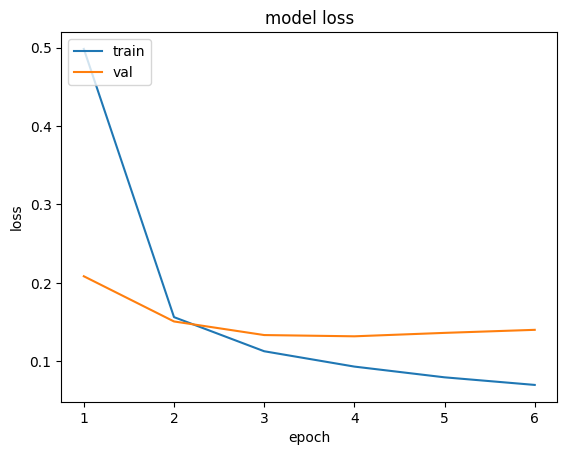

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<Axes: >

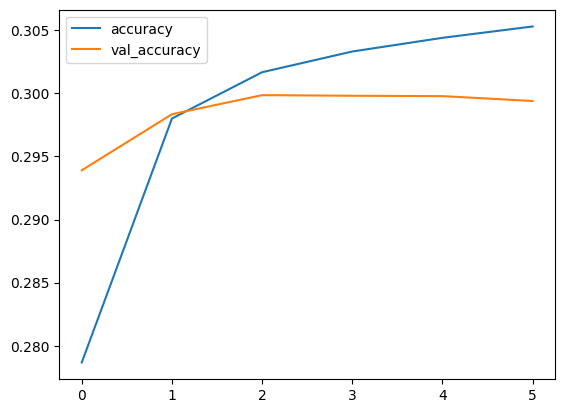

In [ ]:
import pandas as pd
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [ ]:
from seqeval.metrics import f1_score, classification_report

In [ ]:
def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:
y_predicted = model.predict([X_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

  1/300 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step


In [ ]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

         art       0.38      0.08      0.13        63
         eve       0.45      0.29      0.35        52
         geo       0.84      0.84      0.84      7620
         gpe       0.96      0.94      0.95      3145
         nat       0.46      0.30      0.36        37
         org       0.58      0.58      0.58      4033
         per       0.73      0.73      0.73      3545
         tim       0.84      0.86      0.85      4067

   micro avg       0.79      0.79      0.79     22562
   macro avg       0.66      0.58      0.60     22562
weighted avg       0.79      0.79      0.79     22562



## 성능

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 78.9%


# BiLSTM-CRF를 이용한 개체명인식

## 모델링

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras_crf import CRFModel   ## tensorflow 2.17에서 Error!!!
from seqeval.metrics import f1_score, classification_report

In [ ]:
embedding_dim = 128
hidden_units = 64
dropout_ratio = 0.3

sequence_input = Input(shape=(max_len,),dtype=tf.int32, name='sequence_input')

model_embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len)(sequence_input)

model_bilstm = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(model_embedding)

model_dropout = TimeDistributed(Dropout(dropout_ratio))(model_bilstm)

model_dense = TimeDistributed(Dense(tag_size, activation='relu'))(model_dropout)

base = Model(inputs=sequence_input, outputs=model_dense)
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')
model.summary()

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

In [ ]:
%%time
history = model.fit(X_train, y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

In [ ]:
model.load_weights('bilstm_crf/cp.ckpt')

In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]]))[0] # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

In [ ]:
y_predicted = model.predict(X_test)[0]

In [ ]:
def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:
def sequences_to_tag_for_crf(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            # pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            pred_index = pred
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
print(classification_report(test_tags, pred_tags))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.90      0.17      0.29        52
         geo       0.83      0.84      0.84      7620
         gpe       0.95      0.93      0.94      3145
         nat       0.00      0.00      0.00        37
         org       0.64      0.58      0.61      4033
         per       0.76      0.70      0.73      3545
         tim       0.86      0.83      0.85      4067

   micro avg       0.81      0.78      0.80     22562
   macro avg       0.62      0.51      0.53     22562
weighted avg       0.81      0.78      0.79     22562



## 성능

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 79.6%


# BiLSTM-CNN을 이용한 개체명인식

## 모델링

In [ ]:
from tensorflow.keras.layers import Embedding, Input, TimeDistributed, Dropout, concatenate, Bidirectional, LSTM, Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from seqeval.metrics import f1_score, classification_report

In [ ]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.5
hidden_units = 256
num_filters = 30
kernel_size = 3

# 단어 임베딩
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(words_input)

# char 임베딩
character_input = Input(shape=(None, max_len_char,),name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), char_embedding_dim, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout = Dropout(dropout_ratio)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out= TimeDistributed(Conv1D(kernel_size=kernel_size, filters=num_filters, padding='same', activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(dropout_ratio)(char)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([words, char])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(hidden_units, return_sequences=True, dropout=dropout_ratio))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='softmax'))(output)

model = Model(inputs=[words_input, character_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='nadam',  metrics=['acc'])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, None, 15)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embedding            │ (None, None, 15, 64)   │          4,736 │ char_input[0][0]       │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, None, 15, 64)   │              0 │ char_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_6        │ (None, None, 15, 30)   │          5,790 │ dropout_1[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_7        │ (None, None, 1, 30)    │              0 │ time_distributed_6[0]… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ words_input (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_8        │ (None, None, 30)       │              0 │ time_distributed_7[0]… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, None, 128)      │      4,072,832 │ words_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, None, 30)       │              0 │ time_distributed_8[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 158)      │              0 │ embedding_5[0][0],     │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, None, 512)      │        849,920 │ concatenate[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_9        │ (None, None, 18)       │          9,234 │ bidirectional_5[0][0]  │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,942,512 (18.85 MB)

 Trainable params: 4,942,512 (18.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_cnn_ner.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
%%time
# 270/270 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - acc: 0.9935 - loss: 0.0200 - val_acc: 0.9869 - val_loss: 0.0454
# Epoch 10: early stopping
# CPU times: user 50min 28s, sys: 1min 4s, total: 51min 32s
# Wall time: 53min 36s
history = model.fit([X_train, X_char_train], y_train, batch_size=128, epochs=15, validation_split=0.1, verbose=1, callbacks=[es, mc])

Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9191 - loss: 0.3279
Epoch 1: val_acc improved from -inf to 0.98004, saving model to bilstm_cnn_ner.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - acc: 0.9192 - loss: 0.3273 - val_acc: 0.9800 - val_loss: 0.0713
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9832 - loss: 0.0596
Epoch 2: val_acc improved from 0.98004 to 0.98531, saving model to bilstm_cnn_ner.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - acc: 0.9832 - loss: 0.0596 - val_acc: 0.9853 - val_loss: 0.0490
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9878 - loss: 0.0415
Epoch 3: val_acc improved from 0.98531 to 0.98666, saving model to bilstm_cnn_ner.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - acc: 0.9878 - loss: 0.0414 - val_acc: 0.9867 - val_loss: 0.0445
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9898 - loss: 0.0338
Epoch 4: val_acc improved from 0.98666 to 0.98716, saving model to bilstm_cnn_ner.keras
270/270

In [ ]:
model = load_model('bilstm_cnn_ner.keras')

In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


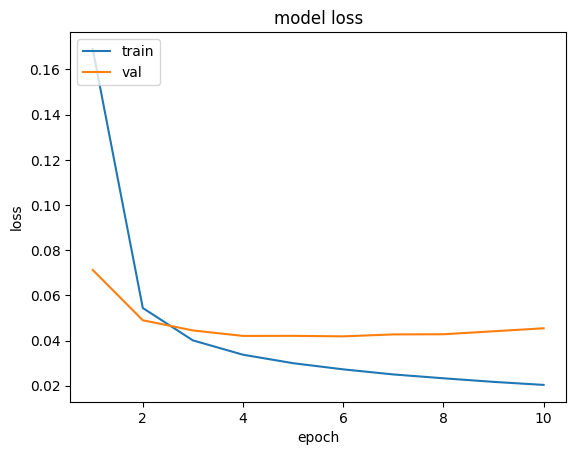

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<Axes: >

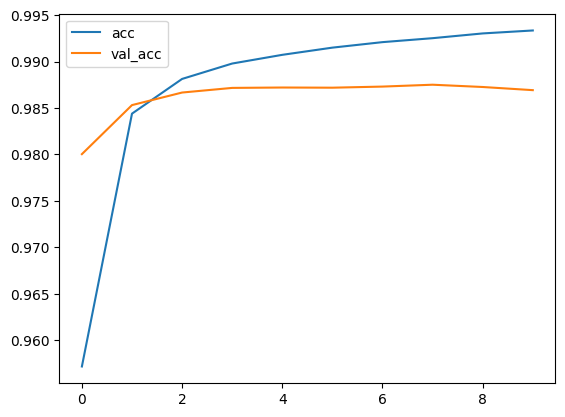

In [ ]:
pd.DataFrame(history.history)[['acc', 'val_acc']].plot()

In [ ]:
def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:
y_predicted = model.predict([X_test, X_char_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


300/300 ━━━━━━━━━━━━━━━━━━━━ 149s 498ms/step


In [ ]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.36      0.27      0.31        52
         geo       0.82      0.86      0.84      7620
         gpe       0.96      0.94      0.95      3145
         nat       0.62      0.14      0.22        37
         org       0.61      0.56      0.59      4033
         per       0.73      0.72      0.73      3545
         tim       0.87      0.84      0.86      4067

   micro avg       0.80      0.79      0.79     22562
   macro avg       0.62      0.54      0.56     22562
weighted avg       0.79      0.79      0.79     22562



## 성능

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 78.9%


#BiLSTM-CNN-CRF를 이용한 개체명인식

## 모델링

In [ ]:
import tensorflow as tf
from keras_crf import CRFModel

In [ ]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.5
hidden_units = 256
num_filters = 30
kernel_size = 3

# 단어 임베딩
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(words_input)

# char 임베딩
character_input = Input(shape=(None, max_len_char,),name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), char_embedding_dim, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout = Dropout(dropout_ratio)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out= TimeDistributed(Conv1D(kernel_size=kernel_size, filters=num_filters, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(dropout_ratio)(char)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([words, char])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(hidden_units, return_sequences=True, dropout=dropout_ratio))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

base = Model(inputs=[words_input, character_input], outputs=[output])
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')
model.summary()

Model: "crf_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, None, 15)]   0           []                               
                                                                                                  
 char_embedding (TimeDistribute  (None, None, 15, 64  4736       ['char_input[0][0]']             
 d)                             )                                                                 
                                                                                                  
 dropout_4 (Dropout)            (None, None, 15, 64  0           ['char_embedding[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_cnn_crf/cp.ckpt', monitor='val_decode_sequence_accuracy',
                     mode='max', verbose=1,
                     save_best_only=True, save_weights_only=True)

조기 종료로 학습이 끝났다면 검증 데이터에 대해서 정확도가 가장 높았을 당시를 저장해둔 가중치를 불러온 후, 테스트 데이터의 13번 인덱스의 샘플에 대해서 예측합니다.

In [ ]:
%%time
history = model.fit([X_train, X_char_train], y_train_int, batch_size=128, epochs=15,
                    validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9270 - loss: 20.0089
Epoch 00001: val_decode_sequence_accuracy improved from -inf to 0.96776, saving model to bilstm_cnn_crf/cp.ckpt
270/270 [==============================] - 59s 193ms/step - decode_sequence_accuracy: 0.9270 - loss: 19.9610 - val_decode_sequence_accuracy: 0.9678 - val_loss: 7.4661
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9787 - loss: 5.1367
Epoch 00002: val_decode_sequence_accuracy improved from 0.96776 to 0.98258, saving model to bilstm_cnn_crf/cp.ckpt
270/270 [==============================] - 45s 167ms/step - decode_sequence_accuracy: 0.9787 - loss: 5.1319 - val_decode_sequence_accuracy: 0.9826 - val_loss: 4.0034
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9856 - loss: 3.1769
Epoch 00003: val_decode_sequence_accuracy improved from 0.98258 to 0.98532, saving model to bilstm_cnn_

조기 종료로 학습이 끝났다면 검증 데이터에 대해서 정확도가 가장 높았을 당시를 저장해둔 가중치를 불러온 후, 테스트 데이터의 13번 인덱스의 샘플에 대해서 예측합니다.

In [ ]:
model.load_weights('bilstm_cnn_crf/cp.ckpt')

In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])[0]
true = np.argmax(y_test[i], -1) # 원-핫 벡터를 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


정확하게 잘 예측한 것 같습니다. 테스트 데이터에 대해서 성능을 측정해봅시다. 테스트 데이터에 대한 예측 시퀀스인 y_predicted를 얻습니다. 예측값과 실제값에 대한 태깅 정보 시퀀스를 얻은 후 F1-score를 계산합니다.

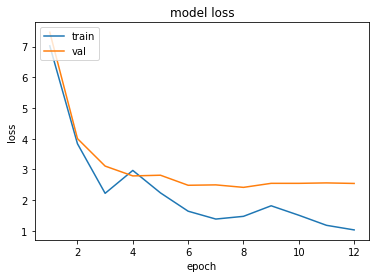

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_predicted = model.predict([X_test, X_char_test])[0]
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
print(classification_report(test_tags, pred_tags))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.00      0.00      0.00        52
         geo       0.80      0.89      0.84      7620
         gpe       0.94      0.94      0.94      3145
         nat       1.00      0.16      0.28        37
         org       0.68      0.55      0.61      4033
         per       0.79      0.73      0.76      3545
         tim       0.88      0.84      0.86      4067

   micro avg       0.82      0.80      0.81     22562
   macro avg       0.64      0.51      0.54     22562
weighted avg       0.81      0.80      0.80     22562



## 성능

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 80.6%


---
## 4. BiLSTM-BiLSTM-CRF
---
문자 임베딩이 활용되는 과정을 보겠습니다. 하나의 단어는 문자 단위로 토큰화되었고, 토큰화 된 각 문자는 위의 전처리를 통해 정수로 맵핑된 상태입니다. 정수로 맵핑된 각 문자는 임베딩 층을 통과하면 64차원의 벡터가 됩니다. 이후 양방향 LSTM 입력으로 사용되는데, 이때 사용되는 LSTM의 은닉 상태의 크기는 64입니다. 해당 LSTM은 다 대 일(many-to-one)구조로 순방향 LSTM의 은닉 상태와 역방향 LSTM의 은닉 상태가 연결(concatenate)된 값이 양방향 LSTM의 출력입니다. 해당 출력을 하나의 단어에 대한 단어 벡터로 간주합니다. 해당 단어 벡터는 일반적으로 워드 임베딩이라고 부르던 과정을 통해 얻은 단어의 임베딩 벡터와 연결(concatenate)됩니다. 이를 개체명 인식을 위한 양방향 LSTM의 입력으로 사용하게 되는데, 이후에는 이전 실습들과 같습니다. CRF 층은 원-핫 인코딩 된 레이블은 지원하지 않으므로 y_train_int를 사용합니다.

## 모델링

In [ ]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.3
hidden_units = 64

# 단어 임베딩
word_ids = Input(batch_shape=(None, None), dtype='int32', name='word_input')
word_embeddings = Embedding(input_dim=vocab_size,
                                        output_dim=embedding_dim,
                                        name='word_embedding')(word_ids)

# char 임베딩
char_ids = Input(batch_shape=(None, None, None), dtype='int32', name='char_input')
char_embeddings = Embedding(input_dim=(len(char_to_index)),
                                        output_dim=char_embedding_dim,
                                        embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5),
                                        name='char_embedding')(char_ids)

# char 임베딩을 BiLSTM을 통과 시켜 단어 벡터를 얻고 단어 임베딩과 연결
char_embeddings = TimeDistributed(Bidirectional(LSTM(hidden_units)))(char_embeddings)
word_embeddings = concatenate([word_embeddings, char_embeddings])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
word_embeddings = Dropout(dropout_ratio)(word_embeddings)
output = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(word_embeddings)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

base = Model(inputs=[word_ids, char_ids], outputs=[output])
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

model.summary()

Model: "crf_model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 word_input (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 char_embedding (Embedding)     (None, None, None,   4736        ['char_input[0][0]']             
                                64)                                                               
                                                                                        

In [ ]:
# callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy',
                     mode='max', verbose=1, save_best_only=True, save_weights_only=True)

In [ ]:
%%time
history = model.fit([X_train, X_char_train], y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9263 - loss: 22.6385
Epoch 00001: val_decode_sequence_accuracy improved from -inf to 0.97024, saving model to bilstm_bilstm_crf/cp.ckpt
270/270 [==============================] - 62s 195ms/step - decode_sequence_accuracy: 0.9263 - loss: 22.5786 - val_decode_sequence_accuracy: 0.9702 - val_loss: 7.3148
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9787 - loss: 4.9090
Epoch 00002: val_decode_sequence_accuracy improved from 0.97024 to 0.98270, saving model to bilstm_bilstm_crf/cp.ckpt
270/270 [==============================] - 47s 173ms/step - decode_sequence_accuracy: 0.9787 - loss: 4.9062 - val_decode_sequence_accuracy: 0.9827 - val_loss: 3.7907
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9852 - loss: 3.0332
Epoch 00003: val_decode_sequence_accuracy improved from 0.98270 to 0.98497, saving model to bilst

조기 종료로 학습이 끝났다면 검증 데이터에 대해서 정확도가 가장 높았을 당시를 저장해둔 가중치를 불러온 후, 테스트 데이터의 13번 인덱스의 샘플에 대해서 예측합니다.

In [ ]:
model.load_weights('bilstm_bilstm_crf/cp.ckpt')

In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])[0]
true = np.argmax(y_test[i], -1) # 원-핫 벡터를 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


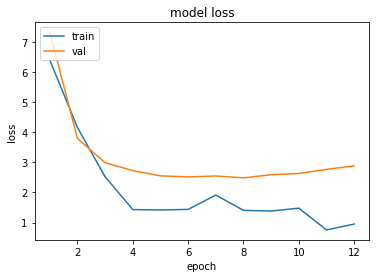

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

정확하게 잘 예측한 것 같습니다. 테스트 데이터에 대해서 성능을 측정해봅시다. 테스트 데이터에 대한 예측 시퀀스인 y_predicted를 얻습니다. 예측값과 실제값에 대한 태깅 정보 시퀀스를 얻은 후 F1-score를 계산합니다.

In [ ]:
y_predicted = model.predict([X_test, X_char_test])[0]
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

         art       0.44      0.06      0.11        63
         eve       0.70      0.27      0.39        52
         geo       0.83      0.87      0.85      7620
         gpe       0.95      0.94      0.94      3145
         nat       0.39      0.19      0.25        37
         org       0.71      0.55      0.62      4033
         per       0.79      0.74      0.76      3545
         tim       0.88      0.84      0.86      4067

   micro avg       0.83      0.79      0.81     22562
   macro avg       0.71      0.56      0.60     22562
weighted avg       0.82      0.79      0.81     22562



## 성능

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 81.1%


마지막 편집일시 : 2022년 11월 14일 4:28 오후